<a href="https://colab.research.google.com/github/ashutosh15072000/Building-LLMs-From-Scratch/blob/main/FineTunning/Coding_a_fine_tuned_LLM_spam_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPT ARCHITECTURE: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [1]:
import torch
import torch.nn as nn

In [2]:
GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias":True
}

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=True):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)


In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [6]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


<div class="alert alert-block alert-warning">
    
The __init__ constructor of this GPTModel class initializes the token and positional
embedding layers using the configurations passed in via a Python dictionary, cfg.

These
embedding layers are responsible for converting input token indices into dense vectors and
adding positional information.
</div>

<div class="alert alert-block alert-warning">
    
Next, the __init__ method creates a sequential stack of TransformerBlock modules
equal to the number of layers specified in cfg.

Following the transformer blocks, a
LayerNorm layer is applied, standardizing the outputs from the transformer blocks to
stabilize the learning process.

Finally, a linear output head without bias is defined, which
projects the transformer's output into the vocabulary space of the tokenizer to generate
logits for each token in the vocabulary.
</div>

<div class="alert alert-block alert-warning">
    
The forward method takes a batch of input token indices, computes their embeddings,
applies the positional embeddings, passes the sequence through the transformer blocks,
normalizes the final output, and then computes the logits, representing the next token's
unnormalized probabilities. We will convert these logits into tokens and text outputs in the
next section.
</div>

<div class="alert alert-block alert-success">
Let's now initialize the 124 million parameter GPT model using the GPT_CONFIG_124M
dictionary we pass into the cfg parameter and feed it with the batch text input we created
at the beginning of this chapter:
</div>

In [7]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.9 MB/s eta 0:00:00


In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [9]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.1620, -0.1536,  0.0213,  ...,  0.1203, -0.6179,  0.1169],
         [ 0.2378, -0.4336,  0.8639,  ..., -0.6176, -1.0692,  0.4272],
         [ 0.5458, -0.2930, -0.3446,  ..., -0.2180, -0.5731, -0.4150],
         [ 0.1631,  0.4854,  0.2531,  ...,  0.2517,  0.2439,  0.2959]],

        [[-0.7108, -0.4756, -0.0811,  ..., -0.4689, -0.5025,  0.0085],
         [ 0.2073, -1.4885,  1.2541,  ..., -0.9367, -0.7631,  0.2164],
         [-0.6036, -0.1086, -0.1497,  ..., -0.2940, -0.3618,  0.3962],
         [-0.1072,  1.1772,  0.6442,  ..., -0.5448, -0.2867, -0.4979]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.
    
</div>

<div class="alert alert-block alert-success">
Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors:
</div>

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,037,184


<div class="alert alert-block alert-danger">
Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?
</div>

<div class="alert alert-block alert-warning">
    
The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer.

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

</div>

In [11]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


<div class="alert alert-block alert-info">

As we can see based on the print outputs, the weight tensors for both these layers have the
same shape:
</div>

<div class="alert alert-block alert-success">
The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:
</div>

In [12]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,439,808


<div class="alert alert-block alert-info">

As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.
</div>

<div class="alert alert-block alert-warning">
    
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

</div>

<div class="alert alert-block alert-success">
Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object:
</div>

In [13]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.94 MB


<div class="alert alert-block alert-warning">
    
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

</div>

<div class="alert alert-block alert-warning">
    
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

</div>

In [14]:
model.parameters

<bound method Module.parameters of GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (2): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (3): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (4): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (5): TransformerBlock(
      (att): MultiHeadAttention(
    

## LOADING PRETRAINED WEIGHTS FROM OPENAI

<div class="alert alert-block alert-success">
    
Previously, for educational purposes, we trained a small GPT-2 model using a limited
dataset comprising a short-story book.

This approach allowed us to focus on the
fundamentals without the need for extensive time and computational resources.

    
Fortunately, OpenAI openly shared the weights of their GPT-2 models, thus eliminating
the need to invest tens to hundreds of thousands of dollars in retraining the model on a
large corpus ourselves.
</div>

<div class="alert alert-block alert-success">
    
In the remainder of this section, we load these weights into our GPTModel class and use
the model for text generation.

Here, weights refer to the weight parameters that are stored
in the .weight attributes of PyTorch's Linear and Embedding layers, for example.

We accessed them earlier via model.parameters() when training the model.
</div>

<div class="alert alert-block alert-success">
    
Note that OpenAI originally saved the GPT-2 weights via TensorFlow, which we have to
install to load the weights in Python.

Moreover, the following code will use a progress bar
tool called tqdm to track the download process, which we also have to install.
</div>

In [15]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

<div class="alert alert-block alert-success">
    
We download the gpt_download.py Python module directly from this chapter's online repository
</div>

<div class="alert alert-block alert-success">
    
We can now import the download_and_load_gpt2 function from the gpt_download.py
file as follows, which will load the GPT-2 architecture settings (settings) and weight
parameters (params) into our Python session:
</div>

In [16]:
from gpt_download3 import download_and_load_gpt2

In [17]:
settings,params=download_and_load_gpt2(model_size="124M",models_dir="gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 166kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.49MiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

<div class="alert alert-block alert-success">
    
After the execution of the previous code has been completed, let's inspect the contents of
settings and params:
</div>

In [18]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


<div class="alert alert-block alert-success">
    
Both settings and params are Python dictionaries. The settings dictionary stores the LLM
architecture settings similarly to our manually defined GPT_CONFIG_124M settings.

The
params dictionary contains the actual weight tensors.

    
Note that we only printed the
dictionary keys because printing the weight contents would take up too much screen space
</div>

<div class="alert alert-block alert-success">
    
We can inspect these weight tensors by printing the whole dictionary via
print(params) or by selecting individual tensors via the respective dictionary keys, for
example, the embedding layer weights:

</div>

In [19]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


<div class="alert alert-block alert-success">
    
We downloaded and loaded the weights of the smallest GPT-2 model via the
download_and_load_gpt2(model_size="124M", ...) setting. However, note that OpenAI
also shares the weights of larger models: "355M", "774M", and "1558M".

</div>

<div class="alert alert-block alert-success">
    
Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance.

First, we initialize a new GPTModel instance.

Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too.
                                                                                                                                                                                                                                                                                                                                  
We are also using the 1024 token context length that was used by the original GPT-2 model(s)

</div>

In [20]:
## Define model congfiguration in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [21]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

<div class="alert alert-block alert-success">
    
Careful readers may remember that we used a 256-token length earlier, but the original
GPT-2 models from OpenAI were trained with a 1,024-token length, so we have to update
the NEW_CONFIG accordingly:

</div>

<div class="alert alert-block alert-success">
    
Also, OpenAI used bias vectors in the multi-head attention module's linear layers to
implement the query, key, and value matrix computations.

Bias vectors are not commonly
used in LLMs anymore as they don't improve the modeling performance and are thus
unnecessary.

However, since we are working with pretrained weights, we need to match the
settings for consistency and enable these bias vectors:

</div>

In [22]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

<div class="alert alert-block alert-success">
    
By default, the GPTModel instance is initialized with random weights for pretraining.

The last
step to using OpenAI's model weights is to override these random weights with the weights
we loaded into the params dictionary.

For this, we will first define a small assign utility function that checks whether two
tensors or arrays (left and right) have the same dimensions or shape and returns the
right tensor as trainable PyTorch parameters:
</div>

In [23]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

<div class="alert alert-block alert-success">
    
Next, we define a load_weights_into_gpt function that loads the weights from the params
dictionary into a GPTModel instance gpt:
</div>

<div class="alert alert-block alert-info">

Step 1: Setting the model's positional and token embedding weights to those specified in params.

Step 2: Iterate over each transformer block in the model.

Step 3: The np.split function is used to divide the attention and bias weights into three equal parts for the query,
key, and value components.
    
Step 4: The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the
total number of parameters, which is a concept known as weight tying.

</div>

In [24]:
import numpy as np
def load_weights_into_gpt(gpt,params):

    ### Assigning the token_emb and pos_emb weight of gpt2 pretrained weight into our gpt model
    gpt.tok_emb.weight=assign(gpt.tok_emb.weight,params["wte"])
    gpt.pos_emb.weight=assign(gpt.pos_emb.weight,params["wpe"])


    for b in range(len(params["blocks"])):
        ## Getting the query,key,values weight from gpt2 orginal model
        q_w,k_w,v_w=np.split((params["blocks"][b]["attn"]["c_attn"])['w'],3,axis=-1)

        ## Assignign the pretrained query_weight into our model
        gpt.trf_blocks[b].att.W_query.weight=assign(gpt.trf_blocks[b].att.W_query.weight,q_w.T)
        ## Assignign the pretrained key_weight into our model
        gpt.trf_blocks[b].att.W_key.weight=assign(gpt.trf_blocks[b].att.W_key.weight,k_w.T)
        ## Assignign the pretrained value_weight into our model
        gpt.trf_blocks[b].att.W_value.weight=assign(gpt.trf_blocks[b].att.W_value.weight,v_w.T)

        ## Getting the query,key,values bias from gpt2 orginal model
        q_b,k_b,v_b=np.split((params['blocks'][b]['attn']["c_attn"])['b'],3,axis=-1)

        ## Assignign the pretrained query_bias into our model
        gpt.trf_blocks[b].att.W_query.bias=assign(gpt.trf_blocks[b].att.W_query.bias,q_b)
         ## Assignign the pretrained key_bias into our model
        gpt.trf_blocks[b].att.W_key.bias=assign(gpt.trf_blocks[b].att.W_key.bias,k_b)
        ## Assignign the pretrained value_bias into our model
        gpt.trf_blocks[b].att.W_value.bias=assign(gpt.trf_blocks[b].att.W_value.bias,v_b)


        gpt.trf_blocks[b].att.out_proj.weight=assign(gpt.trf_blocks[b].att.out_proj.weight,params['blocks'][b]['attn']["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias=assign(gpt.trf_blocks[b].att.out_proj.bias,params['blocks'][b]['attn']['c_proj']["b"])

        gpt.trf_blocks[b].ff.layers[0].weight=assign(gpt.trf_blocks[b].ff.layers[0].weight,params['blocks'][b]['mlp']['c_fc']['w'].T)
        gpt.trf_blocks[b].ff.layers[0].bias=assign(gpt.trf_blocks[b].ff.layers[0].bias,params['blocks'][b]['mlp']['c_fc']['b'])

        gpt.trf_blocks[b].ff.layers[2].weight=assign(gpt.trf_blocks[b].ff.layers[2].weight,params['blocks'][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias=assign(gpt.trf_blocks[b].ff.layers[2].bias,params['blocks'][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale=assign(gpt.trf_blocks[b].norm1.scale,params['blocks'][b]['ln_1']['g'])
        gpt.trf_blocks[b].norm1.shift=assign(gpt.trf_blocks[b].norm1.shift,params['blocks'][b]['ln_1']['b'])

        gpt.trf_blocks[b].norm2.scale=assign(gpt.trf_blocks[b].norm2.scale,params['blocks'][b]['ln_2']["g"])
        gpt.trf_blocks[b].norm2.shift=assign(gpt.trf_blocks[b].norm2.shift,params['blocks'][b]["ln_2"]['b'])

    gpt.final_norm.scale=assign(gpt.final_norm.scale,params["g"])
    gpt.final_norm.shift=assign(gpt.final_norm.shift,params["b"])
    gpt.out_head.weight=assign(gpt.out_head.weight,params["wte"])

<div class="alert alert-block alert-success">

In the load_weights_into_gpt function, we carefully match the weights from OpenAI's
implementation with our GPTModel implementation.

To pick a specific example, OpenAI
stored the weight tensor for the output projection layer for the first transformer block as
params["blocks"][0]["attn"]["c_proj"]["w"].
                                                        
In our implementation, this weight
tensor corresponds to gpt.trf_blocks[b].att.out_proj.weight, where gpt is a
GPTModel instance.
</div>

<div class="alert alert-block alert-success">

Developing the load_weights_into_gpt function took a lot of guesswork since OpenAI
used a slightly different naming convention from ours.

However, the assign function would
alert us if we try to match two tensors with different dimensions.

Also, if we made a
mistake in this function, we would notice this as the resulting GPT model would be unable
to produce coherent text.
    
</div>

<div class="alert alert-block alert-success">

Let's now try the load_weights_into_gpt out in practice and load the OpenAI model
weights into our GPTModel instance gpt:
    
</div>

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

<div class="alert alert-block alert-success">

If the model is loaded correctly, we can now use it to generate new text using our previous
generate function:
    
</div>

In [27]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [28]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [29]:
torch.manual_seed(143)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you further along. Eventually it would be better to wait to get to where you are, and look for ways to expand beyond that


<div class="alert alert-block alert-warning">

We can be confident that we loaded the model weights correctly because the model can
produce coherent text.

A tiny mistake in this process would cause the model to fail.

    
In the following chapters, we will work further with this pretrained model and fine-tune it
to classify text and follow instructions.
</div>

## ADDING A CLASSIFICATION HEAD

<div class="alert alert-block alert-success">

In this section, we modify the pretrained large language model to prepare it for
classification-finetuning.

To do this, we replace the original output layer, which maps the
hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to
two classes: 0 ("not spam") and 1 ("spam"),
    
</div>

<div class="alert alert-block alert-warning">

We could technically use a single output node since we are dealing with a binary
classification task.

However, this would require modifying the loss function.

Therefore, we choose a
more general approach where the number of output nodes matches the number of
classes.

For example, for a 3-class problem, such as classifying news articles as
"Technology", "Sports", or "Politics", we would use three output nodes, and so forth.
</div>

<div class="alert alert-block alert-success">

Before we attempt to construct the modified architecture, let's print the model
architecture via print(model), which prints the following:
    
</div>

In [30]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

<div class="alert alert-block alert-info">

Above, we can see the GPT architecture neatly laid out.

As
discussed earlier, the GPTModel consists of embedding layers followed by 12 identical
transformer blocks (only the last block is shown for brevity), followed by a final LayerNorm
and the output layer, out_head.

</div>

<div class="alert alert-block alert-success">

Next, we replace the out_head with a new output layer, as illustrated in figure 6.9, that
we will finetune.    
</div>

<div class="alert alert-block alert-success">

To get the model ready for classification-finetuning, we first freeze the model, meaning that
we make all layers non-trainable:

</div>

In [31]:
for param in model.parameters():
    param.requires_grad=False

<div class="alert alert-block alert-success">

Then, we replace the output layer (model.out_head), which
originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary):
</div>

In [32]:
CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [33]:
torch.manual_seed(123)

num_classes=2
model.out_head=torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'],out_features=num_classes)

<div class="alert alert-block alert-warning">

Note that in the preceding code, we use BASE_CONFIG["emb_dim"], which is equal to 768 in
the "gpt2-small (124M)" model, to keep the code below more general.

This means we
can also use the same code to work with the larger GPT-2 model variants.

This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.
</div>

<div class="alert alert-block alert-success">

Additionally, we configure the last transformer block and the final LayerNorm module,
which connects this block to the output layer, to be trainable
    
</div>

In [34]:
model.final_norm

LayerNorm()

In [35]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

<div class="alert alert-block alert-warning">

Even though we added a new output layer and marked certain layers as trainable or nontrainable, we can still use this model in a similar way to previous chapters.

For instance, we
can feed it an example text identical to how we have done it in earlier chapters. For
example, consider the following example text:

</div>

In [36]:
inputs=tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs :",inputs)
print("Outputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens, num_classes)

Inputs : tensor([[5211,  345,  423,  640]])
Outputs dimensions: torch.Size([1, 4])


<div class="alert alert-block alert-success">

Then, we can pass the encoded token IDs to the model as usual:
    
</div>

In [37]:
with torch.no_grad():
    outputs=model(inputs)
print("Outputs:\n",outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-0.2641,  0.1904],
         [ 0.2541, -0.3994],
         [-1.3597,  0.0354],
         [ 0.3399,  0.2329]]])
Outputs dimensions: torch.Size([1, 4, 2])


<div class="alert alert-block alert-info">

In earlier chapters, a similar input would have produced an output tensor of [1, 4, 50257],
where 50,257 represents the vocabulary size.

As in previous chapters, the number of
output rows corresponds to the number of input tokens (in this case, 4).

However, each
output's embedding dimension (the number of columns) is now reduced to 2 instead of
50,257 since we replaced the output layer of the model.

</div>

<div class="alert alert-block alert-warning">

Remember that we are interested in finetuning this model so that it returns a class label
that indicates whether a model input is spam or not spam.

To achieve this, we don't need to
finetune all 4 output rows but can focus on a single output token.

In particular, we will
focus on the last row corresponding to the last output token
</div>

<div class="alert alert-block alert-success">

To extract the last output token, illustrated in figure 6.11, from the output tensor, we
use the following code:    
</div>

In [38]:
print("Last output token:",outputs[:,-1,:])

Last output token: tensor([[0.3399, 0.2329]])


<div class="alert alert-block alert-info">

Having modified the model, the next section will detail the process of transforming the
last token into class label predictions and calculate the model's initial prediction accuracy.

Following this, we will finetune the model for the spam classification task in the subsequent
section.

</div>

### CREATING DATALOADERS

<div class="alert alert-block alert-success">

Previously, we utilized a sliding window technique to generate uniformly
sized text chunks, which were then grouped into batches for more efficient model training.
Each chunk functioned as an individual training instance

In the case of email spam classification, have two primary options:

(1) Truncate all messages to the length of the shortest message in the
dataset or batch.

(2) Pad all messages to the length of the longest message in the dataset or
batch.
    
</div>

<div class="alert alert-block alert-warning">

Option 1 is computationally cheaper, but it may result in significant information loss if
shorter messages are much smaller than the average or longest messages, potentially
reducing model performance.

So, we opt for the second option, which preserves the entire
content of all messages.

To implement option 2, where all messages are padded to the length of the longest
message in the dataset, we add padding tokens to all shorter messages.

For this purpose,
we use "<|endoftext|>" as a padding token, as discussed in chapter 2.

    
However, instead of appending the string "<|endoftext|>" to each of the text messages
directly, we can add the token ID corresponding to "<|endoftext|>" to the encoded text
</div>

<div class="alert alert-block alert-success">

As we have seen earlier, we first need to implement a PyTorch Dataset, which
specifies how the data is loaded and processed, before we can instantiate the data loaders.
    
</div>

<div class="alert alert-block alert-success">

For this purpose, we define the SpamDataset class.

This SpamDataset class handles several key tasks: it identifies the
longest sequence in the training dataset, encodes the text messages, and ensures that all
other sequences are padded with a padding token to match the length of the longest
sequence.
    
</div>

In [39]:
import torch
from torch.utils.data import Dataset
import pandas as pd
class SpamDataset(Dataset):
    def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
        ## Loading the data
        self.data=pd.read_csv(csv_file)

        ## Pretokenized Texts
        self.encoded_texts=[tokenizer.encode(text) for text in self.data['Text']]

        ## If max_length is not set
        if max_length is None:
            self.max_length=self._longest_encoded_length()
        ## Else max_length is set
        else:
            self.max_length=max_length

            ## Truncate the sequences if they are longer than max_length
            self.encoded_texts=[encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

        ## Pad Sequences to the longest sequence
        self.encoded_texts=[encoded_text+[pad_token_id]*(self.max_length-len(encoded_text)) for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )


    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length=0
        for encoded_text in self.encoded_texts:
            encoded_text=len(encoded_text)
            if encoded_text>max_length:
                max_length=encoded_text
        return max_length

<div class="alert alert-block alert-info">

Step 1: Pre-tokenize texts
    
Step 2: Truncate sequences if they are longer than max_length
    
Step 3: Pad sequences to the longest sequence

</div>

<div class="alert alert-block alert-warning">

The SpamDataset class loads data from the CSV files we created earlier, tokenizes the text
using the GPT-2 tokenizer from tiktoken and allows us to pad or truncate the sequences to
a uniform length determined by either the longest sequence or a predefined maximum
length.
</div>

<div class="alert alert-block alert-success">

This ensures each input tensor is of the same size, which is necessary to create the
batches in the training data loader we implement next:
    
</div>

In [44]:
file_path_train="/content/train.csv"

In [45]:
train_dataset=SpamDataset(
    csv_file=file_path_train,
    max_length=None,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

120


<div class="alert alert-block alert-info">

The code outputs 120, showing that the longest sequence contains no more than 120
tokens, a common length for text messages.
                       
It's worth noting that the model can handle
sequences of up to 1,024 tokens, given its context length limit.

If your dataset includes
longer texts, you can pass max_length=1024 when creating the training dataset in the
preceding code to ensure that the data does not exceed the model's supported input
(context) length.

</div>

<div class="alert alert-block alert-success">

Next, we pad the validation and test sets to match the length of the longest training
sequence.

It's important to note that any validation and test set samples exceeding the
length of the longest training example are truncated using
encoded_text[:self.max_length] in the SpamDataset code we defined earlier.

This
truncation is optional; you could also set max_length=None for both validation and test
sets, provided there are no sequences exceeding 1,024 tokens in these sets
</div>

In [46]:
file_path_test="/content/test.csv"
file_path_validation="/content/validation.csv"

In [47]:
val_dataset = SpamDataset(
    csv_file=file_path_test,
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file=file_path_validation,
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


<div class="alert alert-block alert-success">

Using the datasets as inputs, we can instantiate the data loaders similarly to what we did earlier.

However, in this case, the targets represent class labels rather than the next
tokens in the text.

For instance, choosing a batch size of 8, each batch will consist of 8
training examples of length 120 and the corresponding class label of each example.
</div>

In [48]:
from torch.utils.data import DataLoader

num_workers=0
batch_size=8

torch.manual_seed(123)

train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

test_loader=DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)


<div class="alert alert-block alert-success">

To ensure that the data loaders are working and are indeed returning batches of the
expected size, we iterate over the training loader and then print the tensor dimensions of
the last batch:

</div>

In [49]:
for input_batch, target_batch in train_loader:
    print(input_batch,target_batch)
    break

tensor([[   56,    64,   655,  5149,   450,    83,   294,    83,  4519,   492,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [   40,  1464,  8537,   351,   345,    13, 

In [50]:
print("Train loader:")
for input_batch,target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


<div class="alert alert-block alert-info">

As we can see, the input batches consist of 8 training examples with 120 tokens each, as
expected.

The label tensor stores the class labels corresponding to the 8 training examples.

</div>

<div class="alert alert-block alert-success">

Lastly, to get an idea of the dataset size, let's print the total number of batches in each
dataset:
</div>

In [51]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
38 validation batches
19 test batches


## CALCULATING THE CLASSIFICATION LOSS AND ACCURACY

<div class="alert alert-block alert-success">

So far in this chapter, we have prepared the dataset, loaded a pretrained model, and
modified it for classification-finetuning.
           
Before we proceed with the finetuning itself, only
one small part remains: implementing the model evaluation functions used during
finetuning,  
</div>

<div class="alert alert-block alert-success">

Before implementing the evaluation utilities, let's briefly discuss how we convert the model
outputs into class label predictions.
</div>

<div class="alert alert-block alert-warning">

In the previous chapter, we computed the token ID of the next token generated by the
LLM by converting the 50,257 outputs into probabilities via the softmax function and then
returning the position of the highest probability via the argmax function.

In this chapter, we
take the same approach to calculate whether the model outputs a "spam" or "not spam"
prediction for a given input, with the only difference being that we
work with 2-dimensional instead of 50,257-dimensional outputs.
    
</div>

<div class="alert alert-block alert-success">

Let's consider the last token output from
the previous section:

</div>

In [52]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[0.3399, 0.2329]])


<div class="alert alert-block alert-success">
We can obtain the class label via the following code:
</div>

In [53]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 0


<div class="alert alert-block alert-success">
This concept can be used to compute the so-called classification accuracy, which measures
the percentage of correct predictions across a dataset.
</div>

<div class="alert alert-block alert-success">
To determine the classification accuracy, we apply the argmax-based prediction code to
all examples in the dataset and calculate the proportion of correct predictions by defining a
calc_accuracy_loader function:
</div>

In [54]:
def  calc_accuracy_loader(data_loader,model,device,num_batches=None):
    model.eval()
    correcr_predictions,num_examples=0,0

    if num_batches is None:
        num_batches=len(data_loader)
    else:
        num_batches=min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            input_batch,target_batch=input_batch.to(device),target_batch.to(device)
            with torch.no_grad():
                ## Logits of the last output token
                logits=model(input_batch)[:,-1,:]
                predicted_labels=torch.argmax(logits,dim=-1)

                num_examples+=predicted_labels.shape[0]
                correcr_predictions+=(predicted_labels==target_batch).sum().item()
        else:
            break
    return correcr_predictions/num_examples

<div class="alert alert-block alert-success">
Let's use the function to determine the classification accuracies across various datasets
estimated from 10 batches for efficiency:
</div>

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 53.75%
Validation accuracy: 51.25%
Test accuracy: 55.00%


<div class="alert alert-block alert-info">
    
As we can see, the prediction accuracies are near a random prediction, which would be
50% in this case.

To improve the prediction accuracies, we need to finetune the model.

</div>

<div class="alert alert-block alert-warning">

Classification accuracy is not a differentiable function, so we use cross entropy
loss as a proxy to maximize accuracy.

This is the same cross entropy loss discussed earlier.

Accordingly, the calc_loss_batch function remains the same as in earlier, with one
adjustment: we focus on optimizing only the last token, model(input_batch)[:, -1, :],
rather than all tokens, model(input_batch):

</div>

In [56]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch=input_batch.to(device),target_batch.to(device)
    logits=model(input_batch)[:,-1,:]
    loss=torch.nn.functional.cross_entropy(logits,target_batch)
    return loss

<div class="alert alert-block alert-success">
We use the calc_loss_batch function to compute the loss for a single batch obtained from
the previously defined data loaders. To calculate the loss for all batches in a data loader, we
define the calc_loss_loader function
</div>

In [57]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss=0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/num_batches

<div class="alert alert-block alert-success">
Similar to calculating the training accuracy, we now compute the initial loss for each
data set:
</div>

In [58]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.782
Validation loss: 0.814
Test loss: 0.767


<div class="alert alert-block alert-success">

In the next section, we will implement a training function to finetune the model, which
means adjusting the model to minimize the training set loss.

Minimizing the training set
loss will help increase the classification accuracy, our overall goal
</div>

## FINETUNING THE MODEL ON SUPERVISED DATA

<div class="alert alert-block alert-success">

In this section, we define and use the training function to finetune the pretrained LLM and
improve its spam classification accuracy.
    
The training loop is the
same overall training loop we used earlier, with the only difference being that we
calculate the classification accuracy instead of generating a sample text for evaluating the
model.

</div>

<div class="alert alert-block alert-success">

The training function also closely mirrors
the train_model_simple function used for pretraining the model earlier.
                                    
The only two distinctions are that we now track the number of training examples seen
(examples_seen) instead of the number of tokens, and we calculate the accuracy after each
epoch instead of printing a sample text:

</div>

<div class="alert alert-block alert-info">
    
Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

</div>

In [59]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss

In [64]:
## Overall the same as `train_model_simple` in chapter 5

def train_classifier_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter):
    ## Initialize lists to track losses and example seen
    train_losses ,val_losses,train_accs,val_accs=[],[],[],[]
    example_seen,global_step = 0,-1
    ## Main training loop

    for epoch in range(num_epochs):
        model.train() ## Set model to training mode

        for input_batch,target_batch in train_loader:
            ## Reste loss gradients from previous iteration
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            ## Calculate the loss gradient
            loss.backward()
            ## Update model weights using loss gradient
            optimizer.step()
            ## Track example instead of tokens
            example_seen+=input_batch.shape[0]

            global_step+=1

            ## Optional evaluation step
            if global_step % eval_freq==0:
                train_loss,val_loss=evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        ## Calculate accuracy after each epoch
        train_accuracy=calc_accuracy_loader(train_loader,model,device,num_batches=eval_iter)
        val_accuracy=calc_accuracy_loader(val_loader,model,device,num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses,val_losses,train_accs,val_accs,example_seen


<div class="alert alert-block alert-success">

The evaluate_model function used in the train_classifier_simple is the same as the one we used earlier.

</div>

<div class="alert alert-block alert-success">

Next, we initialize the optimizer, set the number of training epochs, and initiate the training
using the train_classifier_simple function.

We will discuss the choice of the the number
of training epochs after we evaluated the results.

The training takes about 6 minutes on an
M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU:
</div>

In [65]:
import time

start_time=time.time()

torch.manual_seed(123)

optimizer=torch.optim.AdamW(model.parameters(),lr=5e-5,weight_decay=0.1)

num_epoch=10

train_losses,val_losses,train_accs,val_accs,examples_seen=train_classifier_simple(model,train_loader,val_loader,optimizer,device,num_epochs=num_epoch,eval_freq=50,eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.480, Val loss 0.462
Ep 1 (Step 000050): Train loss 0.621, Val loss 0.682
Ep 1 (Step 000100): Train loss 0.286, Val loss 0.435
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.758, Val loss 0.564
Ep 2 (Step 000200): Train loss 0.566, Val loss 0.413
Ep 2 (Step 000250): Train loss 0.922, Val loss 0.906
Training accuracy: 52.50% | Validation accuracy: 45.00%
Ep 3 (Step 000300): Train loss 0.295, Val loss 0.457
Ep 3 (Step 000350): Train loss 0.801, Val loss 0.788
Training accuracy: 85.00% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.096, Val loss 0.692
Ep 4 (Step 000450): Train loss 0.368, Val loss 0.408
Ep 4 (Step 000500): Train loss 1.426, Val loss 1.434
Training accuracy: 50.00% | Validation accuracy: 47.50%
Ep 5 (Step 000550): Train loss 0.437, Val loss 0.459
Ep 5 (Step 000600): Train loss 0.863, Val loss 0.701
Training accuracy: 85.00% | Validation accuracy: 87.50%
Ep 6 (Step 000650): Train loss 

<div class="alert alert-block alert-success">

We then use matplotlib to plot the loss function for the training and
validation set:
    
</div>

In [66]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

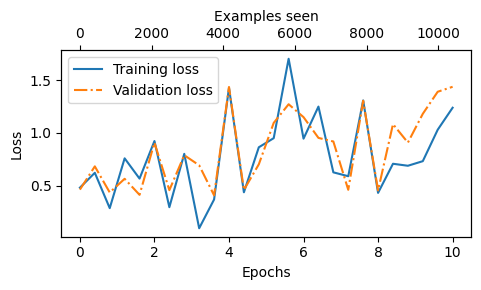

In [67]:
epochs_tensor = torch.linspace(0, num_epoch, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

<div class="alert alert-block alert-info">
    
As we can see based on the sharp downward slope, the model is learning well
from the training data, and there is little to no indication of overfitting; that is, there is no
noticeable gap between the training and validation set losses).

</div>

<div class="alert alert-block alert-success">

Using the same plot_values function, let's now also plot the classification accuracies:

</div>

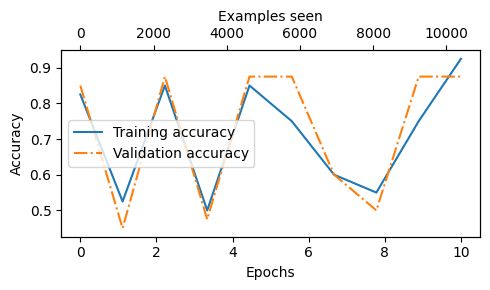

In [68]:
epochs_tensor = torch.linspace(0, num_epoch, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

<div class="alert alert-block alert-info">
    
Based on the accuracy plot in figure 6.17, the model achieves a relatively high training and
validation accuracy after epochs 4 and 5.
    
However, it's important to note that we previously set eval_iter=5 when using the
train_classifier_simple function, which means our estimations of training and
validation performance were based on only 5 batches for efficiency during training.

Now, we will calculate the performance metrics for the training, validation, and test sets
across the entire dataset by running the following code, this time without defining the
eval_iter value:

</div>

In [69]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 83.65%
Validation accuracy: 82.33%
Test accuracy: 81.88%


<div class="alert alert-block alert-warning">

The training and test set performances are almost identical.

A slight discrepancy between the training and test set accuracies suggests minimal
overfitting of the training data.

Typically, the validation set accuracy is somewhat higher
than the test set accuracy because the model development often involves tuning
hyperparameters to perform well on the validation set, which might not generalize as
effectively to the test set.

This situation is common, but the gap could potentially be minimized by adjusting the
model's settings, such as increasing the dropout rate (drop_rate) or the weight_decay
parameter in the optimizer configuration.

</div>

## USING THE LLM AS A SPAM CLASSIFIER

<div class="alert alert-block alert-success">

After finetuning and evaluating the model in the previous sections, we are now in the final
stage of this chapter:  using the model to classify spam
messages.
</div>

<div class="alert alert-block alert-success">

Finally, let's use the finetuned GPT-based spam classification model.

The following
classify_review function follows data preprocessing steps similar to those we used in the
SpamDataset implemented earlier in this chapter.

And then, after processing text into token
IDs, the function uses the model to predict an integer class label, similar to what we have
implemented earlier, and then returns the corresponding class name:
</div>

<div class="alert alert-block alert-info">
    
Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

</div>

In [70]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

<div class="alert alert-block alert-success">

Let's try this classify_review function on an example text:
</div>

In [71]:
text_1 = (
    """URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED.
      Call 09058094455 from land line. Claim 3030. Valid 12hrs only"""
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [72]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


<div class="alert alert-block alert-info">
    
Also, here, the model makes a correct prediction and returns a "not spam" label.
</div>

<div class="alert alert-block alert-success">

Finally, let's save the model in case we want to reuse the model later without having to
train it again using the torch.save method
</div>

In [73]:
torch.save(model.state_dict(), "review_classifier.pth")


<div class="alert alert-block alert-success">

Once saved, the model can be loaded as follows:
</div>

In [74]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<ipython-input-74-90e768cf9e7a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth")


<All keys matched successfully>